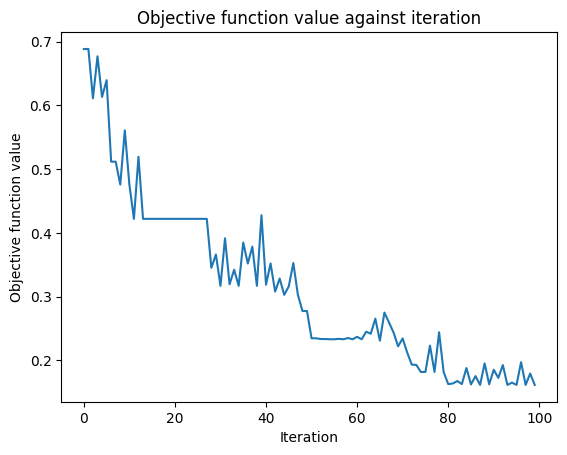

Acurácia no teste: 100.0%
Acurácia no treinamento: 100.0%


In [2]:
#BACKEND REAL
# === IMPORTAÇÕES ===
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit.primitives import Sampler
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.model_selection import train_test_split

# === CONFIGURAÇÃO INICIAL ===
algorithm_globals.random_seed = 12345
QiskitRuntimeService.save_account(channel="ibm_quantum", token="59683a5f7bfd820999fe62ec0ef88dded98950e9b3fbf89ff79b1fbce146adc33a3c0a9181036989098063db0385436f623815dfd9d2df22260501c636ef8158", overwrite=True)
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
print(f"Usando backend: {backend.name}")

# === DEFINIÇÃO DAS CAMADAS ===
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index:param_index+3]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index:param_index+3]), [q1, q2])
        qc.barrier()
        param_index += 3
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=len(sources) * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index:param_index+3]), [source, sink])
        qc.barrier()
        param_index += 3
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((2, 4))
    ver_array = np.zeros((2, 4))

    hor_array[0][1] = hor_array[0][2] = np.pi / 2
    hor_array[1][0] = hor_array[1][1] = np.pi / 2

    ver_array[0][0] = ver_array[0][2] = np.pi / 2
    ver_array[1][1] = ver_array[1][3] = np.pi / 2

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(0)
            random_image = algorithm_globals.random.integers(0, 2)
            images.append(np.array(hor_array[random_image % 2]))
        else:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 2)
            images.append(np.array(ver_array[random_image % 2]))

        for i in range(4):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)

    return images, labels

# === DADOS ===
images, labels = generate_dataset(50)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=246)

# Usando 4 qubits
num_qubits = 4
feature_map = ZFeatureMap(num_qubits)
ansatz = QuantumCircuit(num_qubits)

# Layers adaptados
ansatz.compose(conv_layer(4, "c1"), list(range(4)), inplace=True)
ansatz.compose(pool_layer([0, 1], [2, 3], "p1"), list(range(4)), inplace=True)
ansatz.compose(conv_layer(2, "c2"), list(range(2, 4)), inplace=True)
ansatz.compose(pool_layer([0], [1], "p2"), list(range(2, 4)), inplace=True)

# Combine
circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, range(num_qubits), inplace=True)
circuit.compose(ansatz, range(num_qubits), inplace=True)

print(f"Qubits finais no circuito: {circuit.num_qubits}")


# === CQNN COM FAKE BACKEND  ===
with Session(backend=backend) as session:
    sampler = Sampler()
    qnn = SamplerQNN(
        sampler=sampler,
        circuit=circuit,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        interpret=lambda x: x % 2,
        output_shape=2
    )

    # === CALLBACK ===
    objective_func_vals = []
    def callback_graph(weights, loss):
        objective_func_vals.append(loss)
        clear_output(wait=True)
        plt.plot(objective_func_vals)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.show()

    # === CLASSIFICADOR ===
    initial_point = np.random.rand(len(ansatz.parameters)).tolist()
    with open("12_qcnn_initial_point.json", "w") as f:
        json.dump(initial_point, f)

    classifier = NeuralNetworkClassifier(
        neural_network=qnn,
        optimizer=COBYLA(maxiter=100),
        callback=callback_graph,
        initial_point=initial_point
    )

    x = np.asarray(train_images)
    y = np.asarray(train_labels)
    classifier.fit(x, y)

x_test = np.asarray(test_images)
y_test = np.asarray(test_labels)
acc_test = classifier.score(x_test, y_test)
acc_train = classifier.score(x,y)
print(f"Acurácia no teste: {round(acc_test * 100, 2)}%")
print(f"Acurácia no treinamento: {round(acc_train * 100, 2)}%")


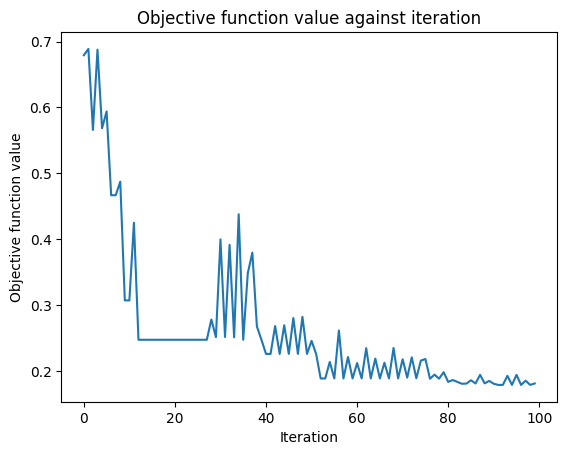

Acurácia no teste: 86.67%
Acurácia no treinamento: 85.71%


In [1]:
# NO FAKE BACKEND
# === IMPORTAÇÕES === 
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.primitives import Sampler
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.model_selection import train_test_split

# === CONFIGURAÇÃO INICIAL ===
algorithm_globals.random_seed = 12345
backend = FakeBrisbane()
print(f"Usando backend: {backend.name}")

# === DEFINIÇÃO DAS CAMADAS ===
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index:param_index+3]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index:param_index+3]), [q1, q2])
        qc.barrier()
        param_index += 3
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=len(sources) * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index:param_index+3]), [source, sink])
        qc.barrier()
        param_index += 3
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((2, 4))
    ver_array = np.zeros((2, 4))

    hor_array[0][1] = hor_array[0][2] = np.pi / 2
    hor_array[1][0] = hor_array[1][1] = np.pi / 2

    ver_array[0][0] = ver_array[0][2] = np.pi / 2
    ver_array[1][1] = ver_array[1][3] = np.pi / 2

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(0)
            random_image = algorithm_globals.random.integers(0, 2)
            images.append(np.array(hor_array[random_image % 2]))
        else:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 2)
            images.append(np.array(ver_array[random_image % 2]))

        for i in range(4):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)

    return images, labels

# === DADOS ===
images, labels = generate_dataset(50)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=246)

# Usando 4 qubits
num_qubits = 4
feature_map = ZFeatureMap(num_qubits)
ansatz = QuantumCircuit(num_qubits)

# Layers adaptados
ansatz.compose(conv_layer(4, "c1"), list(range(4)), inplace=True)
ansatz.compose(pool_layer([0, 1], [2, 3], "p1"), list(range(4)), inplace=True)
ansatz.compose(conv_layer(2, "c2"), list(range(2, 4)), inplace=True)
ansatz.compose(pool_layer([0], [1], "p2"), list(range(2, 4)), inplace=True)

# Combine
circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, range(num_qubits), inplace=True)
circuit.compose(ansatz, range(num_qubits), inplace=True)

print(f"Qubits finais no circuito: {circuit.num_qubits}")


# === QNN COM FAKE BACKEND (sem session) ===
sampler = Sampler()
qnn = SamplerQNN(
    sampler=sampler,
    circuit=circuit,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=lambda x: x % 2,
    output_shape=2
)

# === CALLBACK ===
objective_func_vals = []
def callback_graph(weights, loss):
    objective_func_vals.append(loss)
    clear_output(wait=True)
    plt.plot(objective_func_vals)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.show()

# === CLASSIFICADOR ===
initial_point = np.random.rand(len(ansatz.parameters)).tolist()
with open("12_qcnn_initial_point.json", "w") as f:
    json.dump(initial_point, f)

classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
    initial_point=initial_point
)

x = np.asarray(train_images)
y = np.asarray(train_labels)
classifier.fit(x, y)


x_test = np.asarray(test_images)
y_test = np.asarray(test_labels)
acc_test = classifier.score(x_test, y_test)
acc_train = classifier.score(x,y)
print(f"Acurácia no teste: {round(acc_test * 100, 2)}%")
print(f"Acurácia no treinamento: {round(acc_train * 100, 2)}%")

In [3]:
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython.display import clear_output
# from qiskit import QuantumCircuit, transpile
# from qiskit.circuit import ParameterVector
# from qiskit.circuit.library import ZFeatureMap
# from qiskit.quantum_info import SparsePauliOp
# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
# from qiskit_ibm_runtime.fake_provider import FakeBrisbane
# from qiskit_machine_learning.optimizers import COBYLA
# from qiskit_machine_learning.utils import algorithm_globals
# from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
# from qiskit_machine_learning.neural_networks import SamplerQNN
# from sklearn.model_selection import train_test_split

# # === CONFIGURAÇÃO INICIAL ===
# algorithm_globals.random_seed = 12345
# # QiskitRuntimeService.save_account(channel="ibm_quantum", token="59683a5f7bfd820999fe62ec0ef88dded98950e9b3fbf89ff79b1fbce146adc33a3c0a9181036989098063db0385436f623815dfd9d2df22260501c636ef8158", overwrite=True)
# # service = QiskitRuntimeService()
# # backend = service.least_busy(simulator=True, operational=False)
# backend = FakeBrisbane()
# print(f"Usando backend: {backend.name}")

# # === DEFINIÇÃO DAS CAMADAS ===
# def conv_circuit(params):
#     target = QuantumCircuit(2)
#     target.rz(-np.pi / 2, 1)
#     target.cx(1, 0)
#     target.rz(params[0], 0)
#     target.ry(params[1], 1)
#     target.cx(0, 1)
#     target.ry(params[2], 1)
#     target.cx(1, 0)
#     target.rz(np.pi / 2, 0)
#     return target

# def conv_layer(num_qubits, param_prefix):
#     qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
#     qubits = list(range(num_qubits))
#     param_index = 0
#     params = ParameterVector(param_prefix, length=num_qubits * 3)
#     for q1, q2 in zip(qubits[0::2], qubits[1::2]):
#         qc = qc.compose(conv_circuit(params[param_index:param_index+3]), [q1, q2])
#         qc.barrier()
#         param_index += 3
#     for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
#         qc = qc.compose(conv_circuit(params[param_index:param_index+3]), [q1, q2])
#         qc.barrier()
#         param_index += 3
#     qc_inst = qc.to_instruction()
#     qc = QuantumCircuit(num_qubits)
#     qc.append(qc_inst, qubits)
#     return qc

# def pool_circuit(params):
#     target = QuantumCircuit(2)
#     target.rz(-np.pi / 2, 1)
#     target.cx(1, 0)
#     target.rz(params[0], 0)
#     target.ry(params[1], 1)
#     target.cx(0, 1)
#     target.ry(params[2], 1)
#     return target

# def pool_layer(sources, sinks, param_prefix):
#     num_qubits = len(sources) + len(sinks)
#     qc = QuantumCircuit(num_qubits, name="Pooling Layer")
#     param_index = 0
#     params = ParameterVector(param_prefix, length=len(sources) * 3)
#     for source, sink in zip(sources, sinks):
#         qc = qc.compose(pool_circuit(params[param_index:param_index+3]), [source, sink])
#         qc.barrier()
#         param_index += 3
#     qc_inst = qc.to_instruction()
#     qc = QuantumCircuit(num_qubits)
#     qc.append(qc_inst, range(num_qubits))
#     return qc

# def generate_dataset(num_images):
#     images = []
#     labels = []
#     hor_array = np.zeros((7, 8))
#     ver_array = np.zeros((4, 8))

#     for i in range(0, 7):
#         if i != 3:
#             hor_array[i][i] = np.pi / 2
#             hor_array[i][i + 1] = np.pi / 2

#     for i in range(0, 4):
#         ver_array[i][i] = np.pi / 2
#         ver_array[i][i + 4] = np.pi / 2

#     for n in range(num_images):
#         rng = algorithm_globals.random.integers(0, 2)
#         if rng == 0:
#             labels.append(0)
#             random_image = algorithm_globals.random.integers(0, 6)
#             images.append(np.array(hor_array[random_image]))
#         elif rng == 1:
#             labels.append(1)
#             random_image = algorithm_globals.random.integers(0, 4)
#             images.append(np.array(ver_array[random_image]))

#         for i in range(8):
#             if images[-1][i] == 0:
#                 images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)

#     return images, labels

# # === DADOS ===
# images, labels = generate_dataset(50)
# train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=246)

# feature_map = ZFeatureMap(8)

# ansatz = QuantumCircuit(8, name="Ansatz")
# ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)
# ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)
# ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
# ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)
# ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
# ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# circuit = QuantumCircuit(8)
# circuit.compose(feature_map, range(8), inplace=True)
# circuit.compose(ansatz, range(8), inplace=True)
# circuit = transpile(circuit.decompose(), backend)

# # === QNN com backend real ===
# with Session(backend=backend) as session:
#     sampler = Sampler()
#     qnn = SamplerQNN(
#         sampler=sampler,
#         circuit=circuit,
#         input_params=feature_map.parameters,
#         weight_params=ansatz.parameters,
#         interpret=lambda x: x % 2,
#         output_shape=2
#     )

#     # === CALLBACK ===
#     objective_func_vals = []
#     def callback_graph(weights, loss):
#         objective_func_vals.append(loss)
#         clear_output(wait=True)
#         plt.plot(objective_func_vals)
#         plt.title("Objective function value against iteration")
#         plt.xlabel("Iteration")
#         plt.ylabel("Objective function value")
#         plt.show()

#     # === CLASSIFICADOR ===
#     with open("11_qcnn_initial_point.json", "r") as f:
#         initial_point = json.load(f)

#     classifier = NeuralNetworkClassifier(
#         neural_network=qnn,
#         optimizer=COBYLA(maxiter=200),
#         callback=callback_graph,
#         initial_point=initial_point
#     )

#     x = np.asarray(train_images)
#     y = np.asarray(train_labels)
#     classifier.fit(x, y)

# x_test = np.asarray(test_images)
# y_test = np.asarray(test_labels)
# acc = classifier.score(x_test, y_test)
# print(f"🎯 Acurácia no teste: {round(acc * 100, 2)}%")


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from qiskit_ibm_runtime import QiskitRuntimeService, Session

algorithm_globals.random_seed = 12345
estimator = Estimator()

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

QiskitRuntimeService.save_account(channel="ibm_quantum", token="59683a5f7bfd820999fe62ec0ef88dded98950e9b3fbf89ff79b1fbce146adc33a3c0a9181036989098063db0385436f623815dfd9d2df22260501c636ef8158", overwrite=True)
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True, min_num_qubits=4)
print(f"Usando backend: {backend.name}")


Usando backend: ibm_kyiv


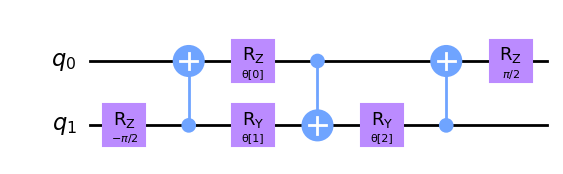

In [ ]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

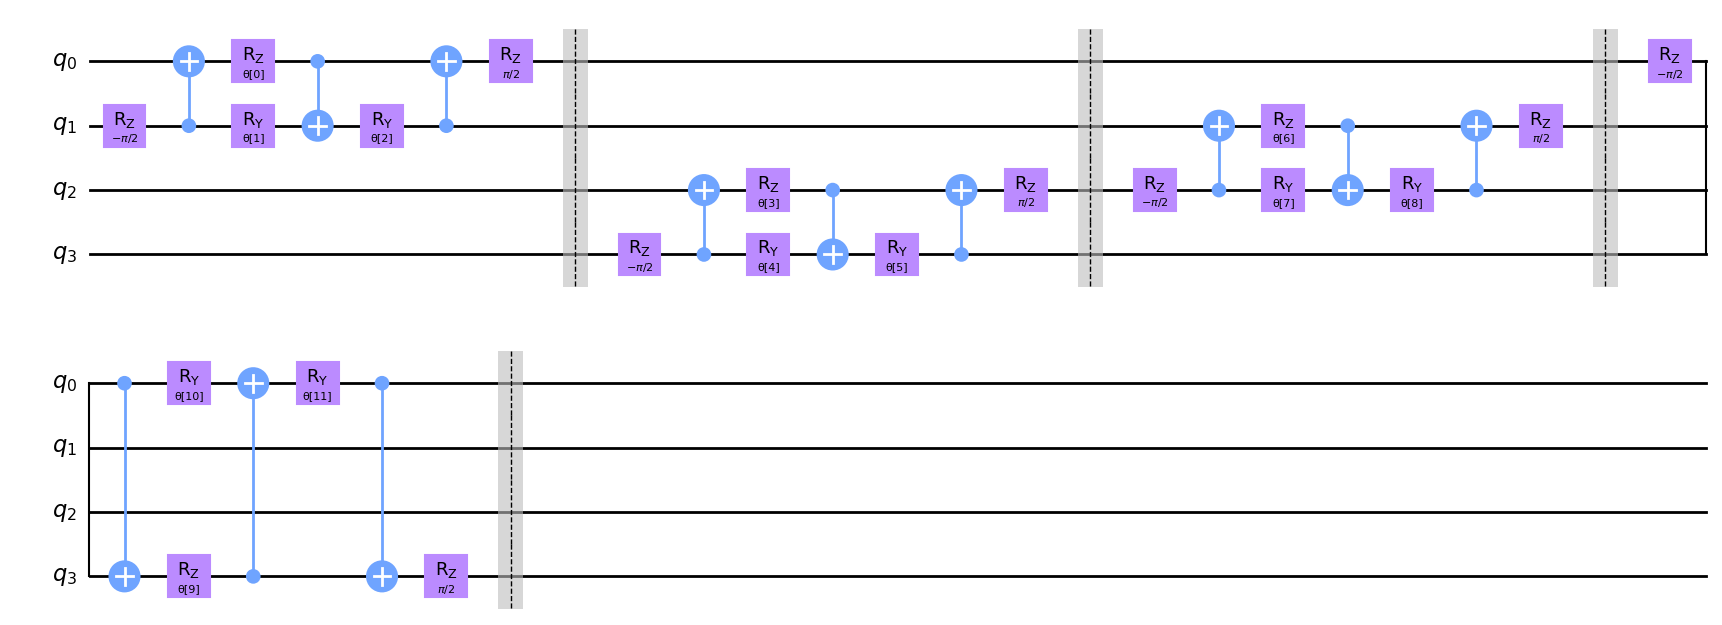

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

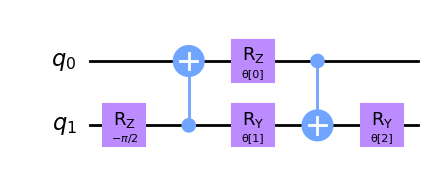

In [ ]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

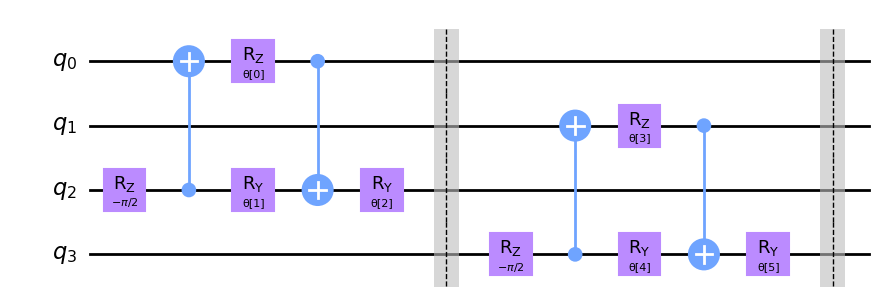

In [ ]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [ ]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [ ]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

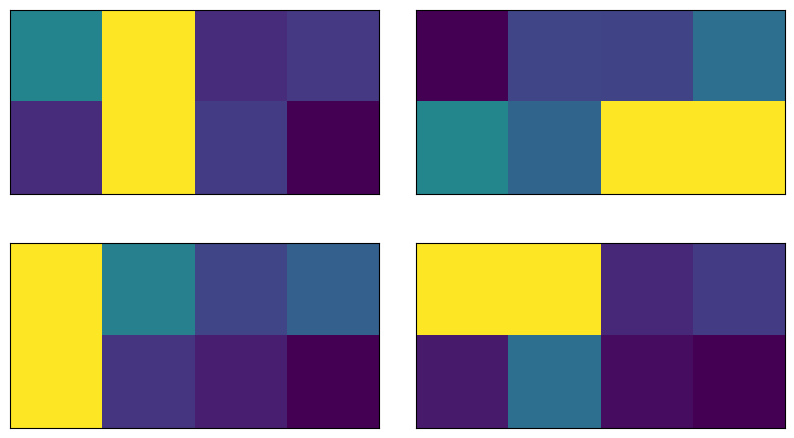

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

In [ ]:
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp

# 4 qubits agora
feature_map = ZFeatureMap(4)

ansatz = QuantumCircuit(4, name="Ansatz")
ansatz.compose(conv_layer(4, "c1"), list(range(4)), inplace=True)
ansatz.compose(pool_layer([0, 1], [2, 3], "p1"), list(range(4)), inplace=True)
ansatz.compose(conv_layer(2, "c2"), list(range(2, 4)), inplace=True)
ansatz.compose(pool_layer([0], [1], "p2"), list(range(2, 4)), inplace=True)

# Juntar feature map + ansatz
circuit = QuantumCircuit(4)
circuit.compose(feature_map, range(4), inplace=True)
circuit.compose(ansatz, range(4), inplace=True)

observable = SparsePauliOp.from_list([("ZIII", 1)])


In [ ]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA

from IPython.display import clear_output
import matplotlib.pyplot as plt

objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Loss vs Iteration")
    plt.plot(objective_func_vals)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

with Session(backend=backend) as session:
    sampler = Sampler()

    qnn = SamplerQNN(
    sampler=sampler,
    circuit=circuit.decompose(),
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    observables=observable
    )

    classifier = NeuralNetworkClassifier(
        qnn=qnn,
        optimizer=COBYLA(maxiter=100),
        callback=callback_graph,
    )

    # Treinamento com dados reduzidos
    x = np.asarray(train_images)[:, :4]  # apenas 4 features (qubits)
    y = np.asarray(train_labels)
    classifier.fit(x, y)


TypeError: SamplerQNN.__init__() got an unexpected keyword argument 'observables'

In [ ]:
x_test = np.asarray(test_images)[:, :4]
y_test = np.asarray(test_labels)

acc = classifier.score(x_test, y_test)
print(f"🎯 Acurácia no teste: {round(acc * 100, 2)}%")
